# Journal 2022-08-20
"Bizarre FOI find of the day: Scotrail has openly published a two-hour long sound file containing every single element of its automated station announcements (link to file)" -- [@jonbradyphoto](https://twitter.com/jonbradyphoto/status/1560630522002321408)

"If anyone needs this split into 2,440 individual mp3s - because why wouldn't you - I've put them here: https://drive.google.com/drive/folders/172W6sXnvlr7UcNLipO8BTw417_KRz9c5?usp=sharing

And if anyone wants to help transcribe all the files, here's a shared sheet, which has a good chance of descending into chaos" -- [@MattEason](https://twitter.com/MattEason/status/1560653413783744512)

Time to play around with [PySoX](https://pysox.readthedocs.io/en/latest/index.html) to see if I can split the files automatically, and maybe then a transcription model e.g. [Wav2Vec](https://www.tensorflow.org/hub/tutorials/wav2vec2_saved_model_finetuning).  Could then compare the transcription results to the Google Doc annotations.

Might also need to play with [some other tools](https://musicinformationretrieval.com/ipython_audio.html)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from wav2vec2 import Wav2Vec2Config
import sox

In [6]:
data_dir = os.path.expanduser('~/Work/Data/ScotRail')
sound_file = os.path.join(data_dir, 'ScotRail_Station_Announcements_June2022.mp3')
label_file = os.path.join(data_dir, 'ScotRail announcements June 2022 index  - Index.csv')

In [11]:
sox.file_info.info(sound_file)

{'channels': 1,
 'sample_rate': 16000.0,
 'bitdepth': None,
 'bitrate': 34700.0,
 'duration': 7585.308,
 'num_samples': 121364928,
 'encoding': 'MPEG audio (layer I, II or III)',
 'silent': False}

Great, looks like the file is already in the 16kHz sample rate needed by Wav2Vec.  Have a look at the community transcriptions now:

In [8]:
df_l = pd.read_csv(label_file)
df_l.loc[:, ['File', 'NRE ID', 'Transcription']].head()

,File,NRE ID,Transcription
0,1,NaN,Platform
1,2,NaN,A trolley service
2,3,WBQ,Warrington Bank Quay
3,4,NaN,South West Trains service to
4,5,NaN,South West Trains service to


First task: use SoX to split the 31MB, 2hr file into the 2440 files.

In [9]:
tfm = sox.Transformer()
tfm.silence(0)  # Remove silence throughout the file
out_array = tfm.build_array(sound_file)

In [10]:
out_array.shape

(55684417,)

In [12]:
tfm.build_file(sound_file, os.path.join(data_dir, 'silence_stripped.mp3'))

True

In [16]:
# Identity transformer to read in the file
tfm_id = sox.Transformer()
orig_array = tfm_id.build_array(sound_file)

In [17]:
orig_array.shape

(121364928,)

In [26]:
np.where(orig_array == 95)[0]

array([     1834,      6200,      7028, ..., 121321412, 121324055,
       121364277])

In [30]:
orig_array[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

In [28]:
orig_array[1834:1834 + 10]

array([  95,   51,  -14,  182,  -53,  154,  -95,  171, -128,  126],
      dtype=int16)

In [29]:
out_array[:10]

array([  95,   51,  -14,  182,  -53,  154,  -95,  171, -128,  126],
      dtype=int16)

SoX may not be the best tool to use here, looks like the `silence` transformer does correctly remove the silent period (listened to output) but doesn't return the locations.  However it does look like the gaps between phrases are actual zero values in the file, so could maybe just split on those?

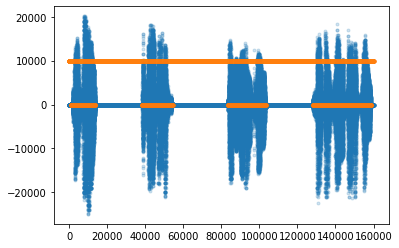

In [41]:
_ = plt.plot(orig_array[:10*16000], alpha=0.2, marker='.', linestyle='none')
_ = plt.plot(np.where(orig_array[:10*16000] <  1, 10000, 0), alpha=0.2, marker='.', linestyle='none')

Ah.  No, lets have a look at what is actually in the gaps

In [42]:
orig_array[20000:20010]

array([-8, -8, -8, -8, -8, -8, -8, -8, -8, -8], dtype=int16)

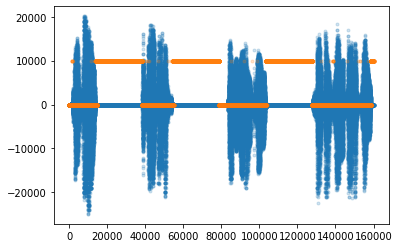

In [43]:
_ = plt.plot(orig_array[:10*16000], alpha=0.2, marker='.', linestyle='none')
_ = plt.plot(np.where(orig_array[:10*16000] == -8, 10000, 0), alpha=0.2, marker='.', linestyle='none')

Ok, maybe splitting on -8 rather than zero, although would need to have a threshold number of bins before splitting.  Below we see that SoX processed silence removed waveform still has some small silences.

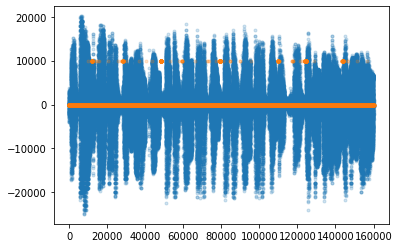

In [44]:
_ = plt.plot(out_array[:10*16000], alpha=0.2, marker='.', linestyle='none')
_ = plt.plot(np.where(out_array[:10*16000] == -8, 10000, 0), alpha=0.2, marker='.', linestyle='none')

Look at a single utterance (first one is 'Platform')

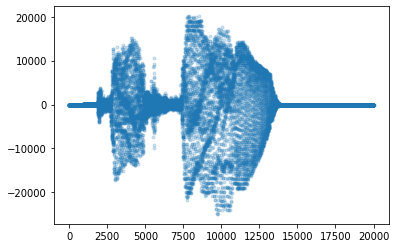

In [45]:
_ = plt.plot(orig_array[:20000], alpha=0.2, marker='.', linestyle='none')

An attempt to try the Wav2Vec model on this utterance following the [Collab Notebook here](https://tfhub.dev/vasudevgupta7/wav2vec2/1)

In [58]:
from wav2vec2 import Wav2Vec2Processor
tokenizer = Wav2Vec2Processor(is_tokenizer=True)
processor = Wav2Vec2Processor(is_tokenizer=False)

In [59]:
def preprocess_text(text):
  label = tokenizer(text)
  return tf.constant(label, dtype=tf.int32)

def preprocess_speech(audio):
  audio = tf.constant(audio, dtype=tf.float32)
  return processor(tf.transpose(audio))

In [62]:
pretrained_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=False)

In [63]:
config = Wav2Vec2Config()

In [64]:
AUDIO_MAXLEN = 246000
LABEL_MAXLEN = 256
BATCH_SIZE = 2

In [65]:
inputs = tf.keras.Input(shape=(AUDIO_MAXLEN,))
hidden_states = pretrained_layer(inputs)
outputs = tf.keras.layers.Dense(config.vocab_size)(hidden_states)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [66]:
model.inputs

[<KerasTensor: shape=(None, 246000) dtype=float32 (created by layer 'input_3')>]

In [69]:
speech = orig_array[:20000].astype(np.float32) #  preprocess_speech(orig_array[:20000])
speech = np.pad(speech, (0, AUDIO_MAXLEN - len(speech)))
speech = tf.expand_dims(processor(tf.constant(speech)), 0)

outputs = model(speech)
outputs

UnimplementedError: Exception encountered when calling layer "keras_layer_1" (type KerasLayer).

Graph execution error:

Fused conv implementation does not support grouped convolutions for now.
	 [[{{node wav2vec2/encoder/pos_conv_embed/conv/Conv1DWithWeightNorm}}]] [Op:__inference_restored_function_body_78382]

Call arguments received by layer "keras_layer_1" (type KerasLayer):
  • inputs=tf.Tensor(shape=(1, 246000), dtype=float32)
  • training=None

An attempt was made.  No success as yet though and time for lunch.